## Convolutional Neural Network Model for Audio Classification

<br/>
by Eduardo Garcia Rajo @ 2019<br/>
<br/>
This notebook if part of the project [Urban sounds classification with Covnolutional Neural Networks](https://github.com/GorillaBus/urban-audio-classifier) on my Github.<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

## Introduction

In this notebook we are going to work with the pre-processed data from the previous notebook.<br/>
<br/>
We are not expecting to find the best possible model at this point, but we can declare the following objectives for this stage: 
<br/>

* Achieve a model architecture that generalizes well: being able to represent the training and the test data
* A test accuracy perhaps over 90%
* A model that does not overfit the training data.
* A train/test loss difference of less than 4%.

<br/>
If we achieve this objectives we will be in a good place to start thinking in more detailed optimizations.<br/>
<br/>
We'll discuss the model architecture, analyze the training history, evaluate the model with the test set and finally we are also going to explore the misclassified samples to see if we can discover some of the reasons for the incorrect category prediction.<br/>
<br/>
<br/>

#### Load required libraries

In [32]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import librosa
import pickle
import matplotlib.pyplot as plt
import random
from datetime import datetime 

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [26]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

#### Define helper functions

In [3]:
# Helper: Generates MFCC coefficients with Librosa 
def get_mfcc(filename, mfcc_max_padding=0):
    try:
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                
        # Should we require padding?
        pad_width = mfcc_max_padding - mfccs.shape[1]
        if (mfcc_max_padding > 0 & mfccs.shape[1] < mfcc_max_padding):
            pad_width = mfcc_max_padding - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", filename)
        return None 
    return mfccs

# Given a file returns a list of prediction results
def predict_from_file(file_name, num_rows, num_columns, num_channels):
    # Note we use num_columns as our padding value!
    feature = get_mfcc(file_name, mfcc_max_padding=num_columns) 
    feature = feature.reshape(1, num_rows, num_columns, num_channels)
    predicted_vector = model.predict_classes(feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba = model.predict_proba(feature)[0]
    return [
        predicted_class,
        predicted_proba
    ]

# Reads the defaul directory for extra evaluation files and returns a pandas dataframe
def get_external_samples(base_path):
    files = []
    labels = []

    # Iterate category directories
    dirs = os.listdir(base_path)
    for d in dirs:
        category = d
        category_path = os.path.join(base_path, d)

        # Iterate files
        dir_files = os.listdir(category_path)

        for file in dir_files:
            file_path = os.path.join(category_path, file)
            files.append(file_path)
            labels.append(category)

    # Create dataframe
    return pd.DataFrame({ 'class': labels, 'file': files })
    
    
def plot_confusion_matrix(y_true, 
                          y_pred, 
                          classes, 
                          normalize=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return [cm, ax]



# Expects a NumPy array with probabilities, retuns accuracy per class
def acc_per_class(np_probs_array):
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = cm[idx][idx].astype(int)
        total = cm[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

def cmvn(vec, variance_normalization=False):
    """ This function is aimed to perform global cepstral mean and
        variance normalization (CMVN) on input feature vector "vec".
        The code assumes that there is one observation per row.
    Args:
        vec (array): input feature matrix
            (size:(num_observation,num_features))
        variance_normalization (bool): If the variance
            normilization should be performed or not.
    Return:
          array: The mean(or mean+variance) normalized feature vector.
    """
    eps = 2**-30
    rows, cols = vec.shape

    # Mean calculation
    norm = np.mean(vec, axis=0)
    norm_vec = np.tile(norm, (rows, 1))

    # Mean subtraction
    mean_subtracted = vec - norm_vec

    # Variance normalization
    if variance_normalization:
        stdev = np.std(mean_subtracted, axis=0)
        stdev_vec = np.tile(stdev, (rows, 1))
        output = mean_subtracted / (stdev_vec + eps)
    else:
        output = mean_subtracted

    return output

### Load data

In [4]:
# Pre-processed MFCC coefficients and labels & metadata

X = np.load("data/X-v1.npy")
y = np.load("data/y-v1.npy")

In [5]:
# Load the metadata from the generated CSV

metadata = pd.read_csv(metadata_path)

### Data preparation: features + metadata

#### Train / Test split

In [6]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Split the features the with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### One hot encode labels

In [7]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


#### Reshape data

In [8]:
# How data should be organized
num_rows = 40
num_columns = 174 # Remember how we padded the data in the previous notebook?
num_channels = 1

# Reshape to fit the network input (channel last!)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

### First model approach

#### Model description

At first I based on what I knew on image classifying architectures and some intuitions I had about convolutioning this type of data (MFCC coefficients of audio signals). This was my very first model:

* Conv2D [32 filters] (5x5) -> ReLU -> MaxPooling -> BatchNorm
* Conv2D [64 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm
* Conv2D [128 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm 
* Conv2D [512 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm
* Flatten -> Dense (256) -> BatchNorm -> Dropout(0.2)
* Dense (128) 
* Softmax (10)

The model overfitted very fast and almost any change that increase the model size -in terms of trainable params- would bring even more overfitting. After simplifying the model as much as I could I finally got more acceptable results to start working with:

* Reduced kernel sizes as much as possible keeping a decreasing pattern (3x3) and (2x2)
* Reduced filter amount to 50%
* Removed the flatten -> dense -> dense sequence and added global average pooling
* Added spatial dropout between convolutions
* Changed all kernel sizes again to (3x3), what reduced training time significantly and achieved better results (~40 epochs less). Many articles state that it's always better to use odd numbers for kernel sizes, this is [an excellent answer](https://datascience.stackexchange.com/questions/23183/why-convolutions-always-use-odd-numbers-as-filter-size) if you also ask yourself why.

This is the final model architecture for this stage after experimentation:<br/>
* Conv2D [32 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout (0.24)
* Conv2D [64 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout (0.24) -> MaxPooling
* Conv2D [128 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout (0.24) -> MaxPooling
* Conv2D [256 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout (0.24)
* Global average pooling 2D
* Softmax

I also started with a learning rate of 1e-3 (default for ADAM) and increassed a bit to 1.5e-3. As I tell later on, we may be able to use even higher rates, but at this point I'm being a bit conservative to avoid complexity.
<br/>
<br/>

### Model definition

In [9]:
model = Sequential()

# Conv 1
model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.24))

# Conv 2
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.24))
model.add(MaxPooling2D(pool_size=2))

# Conv 3
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.24))
model.add(MaxPooling2D(pool_size=2))

# Conv 4
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.24))



# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())

# Softmax output
model.add(Dense(num_labels, activation='softmax'))

W0726 00:44:54.378629 139811092416320 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 00:44:54.400341 139811092416320 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 00:44:54.404235 139811092416320 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 00:44:54.432550 139811092416320 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defaul

#### Model optimizer and loss 

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters for start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [10]:
adam = Adam(lr=1.5e-3, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(X_test, y_test_encoded, verbose=1)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

W0726 00:45:23.831955 139811092416320 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 85, 32)        0         
__________

#### Training the model

In [11]:
num_epochs = 80
num_batch_size = 256
model_file = 'model-A-v1.8.hdf5'
model_path = os.path.join(model_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

W0726 00:45:40.316216 139811092416320 deprecation.py:323] From /home/eduugr/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6986 samples, validate on 1746 samples
Epoch 1/80
6986/6986 [==============================] - 38s 5ms/step - loss: 1.8699 - acc: 0.3385 - val_loss: 1.6191 - val_acc: 0.4393

Epoch 00001: val_loss improved from inf to 1.61910, saving model to models/model-A-v1.8.hdf5
Epoch 2/80
6986/6986 [==============================] - 35s 5ms/step - loss: 1.5632 - acc: 0.4423 - val_loss: 1.3927 - val_acc: 0.5292

Epoch 00002: val_loss improved from 1.61910 to 1.39273, saving model to models/model-A-v1.8.hdf5
Epoch 3/80
6986/6986 [==============================] - 35s 5ms/step - loss: 1.4358 - acc: 0.4865 - val_loss: 1.2786 - val_acc: 0.5578

Epoch 00003: val_loss improved from 1.39273 to 1.27857, saving model to models/model-A-v1.8.hdf5
Epoch 4/80
6986/6986 [==============================] - 35s 5ms/step - loss: 1.3581 - acc: 0.5107 - val_loss: 1.1503 - val_acc: 0.6008

Epoch 00004: val_loss improved from 1.27857 to 1.15032, saving model to models/model-A-v1.8.hdf5
Epoch 5/80
6986/6986 [==


Epoch 00037: val_loss improved from 0.51562 to 0.49783, saving model to models/model-A-v1.8.hdf5
Epoch 38/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.5643 - acc: 0.8156 - val_loss: 0.4720 - val_acc: 0.8505

Epoch 00038: val_loss improved from 0.49783 to 0.47203, saving model to models/model-A-v1.8.hdf5
Epoch 39/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.5672 - acc: 0.8080 - val_loss: 0.4522 - val_acc: 0.8580

Epoch 00039: val_loss improved from 0.47203 to 0.45225, saving model to models/model-A-v1.8.hdf5
Epoch 40/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.5642 - acc: 0.8123 - val_loss: 0.4507 - val_acc: 0.8585

Epoch 00040: val_loss improved from 0.45225 to 0.45072, saving model to models/model-A-v1.8.hdf5
Epoch 41/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.5442 - acc: 0.8199 - val_loss: 0.4630 - val_acc: 0.8511

Epoch 00041: val_loss did not improve from 0.45072
Epoch 42/80


6986/6986 [==============================] - 34s 5ms/step - loss: 0.3590 - acc: 0.8803 - val_loss: 0.2935 - val_acc: 0.9049

Epoch 00076: val_loss did not improve from 0.27994
Epoch 77/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.3516 - acc: 0.8806 - val_loss: 0.2702 - val_acc: 0.9158

Epoch 00077: val_loss improved from 0.27994 to 0.27019, saving model to models/model-A-v1.8.hdf5
Epoch 78/80
6986/6986 [==============================] - 34s 5ms/step - loss: 0.3496 - acc: 0.8843 - val_loss: 0.2675 - val_acc: 0.9135

Epoch 00078: val_loss improved from 0.27019 to 0.26750, saving model to models/model-A-v1.8.hdf5
Epoch 79/80
6986/6986 [==============================] - 34s 5ms/step - loss: 0.3680 - acc: 0.8789 - val_loss: 0.2698 - val_acc: 0.9170

Epoch 00079: val_loss did not improve from 0.26750
Epoch 80/80
6986/6986 [==============================] - 35s 5ms/step - loss: 0.3390 - acc: 0.8838 - val_loss: 0.2606 - val_acc: 0.9192

Epoch 00080: val_loss improved 

### Optional: load previously saved model data

In [27]:
# Optionally load a BEST saved model (if not, you are using the last trained model, pay attention)

model_file_path = os.path.join(models_path, model_file)

print("Loading best saved model: {}".format(model_file_path))

# Load a full model
loaded_model = load_model(model_file_path)


Loading best saved model: /mnt/disks/disk-1/projects/urban-audio-classifier/models/model-A-v1.8.hdf5


### Save the training history

In [31]:
history_file = model_file[:-4] + "dic"
history_file_path = os.path.join(data_path, history_file)

print("Saving training history: {}".format(history_file_path))

with open(history_file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Saving training history: /mnt/disks/disk-1/projects/urban-audio-classifier/data/model-A-v1.8.dic


#### Trained model performance with Train / Test data

In [12]:
# Score on training data
score = model.evaluate(X_train, y_train_encoded, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9529058116403105
Testing Accuracy:  0.9192439863225712


#### Analyze the training history: Train vs Test (loss and accuracy metrics)

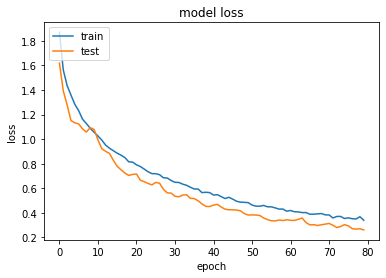

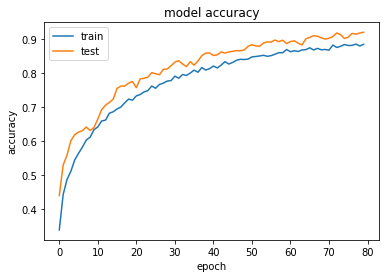

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Observations

The curves displayed in the plot show a small gap between train and validation losses; a noisy but still quite stable gap, what is usually sign of a "healthy" training progress, with no overfitting.<br/>

In my opinion, I think that given the slow rate of change of the decreasing loss we may be able to try a higher learning rates to achieve similar (or better) results in less epochs.
Also, it seems to me that the validation loss curve is not yet tending to flatten much, meaning that we may be able to achieve even higher validation accuracy.


Ideas to improve the model performance avoiding overfitting:
* Increasing regularization by dropout (or L1/L2 maybe?)
* Introducing noise layers (at least on the input) as a regularization factor
* Finding better performing learning rate values
* Working a bit more with pre-processed data: amplitude normalization, MFCC data scaling

<br/>
Overall, with this outcome we are in good place to start working on tunning and optimizing the whole process.
<br/>

## Model evaluation
Now let's see how the model performs with data from the test set.

### Random tests on the test set
(Press Ctrl + Enter to re-randomize)<br/>
<br/>

Let's play around a bit by just making predictions on random test data and see how the model performs while also observing probabilies, metrics and listening to the data.


In [35]:
# Get a random file
row = test_meta.sample(1)
idx = row.index.values.astype(int)[0]

fold_num = str(row.iloc[0,5])
file_name = str(row.iloc[0,0])
category = str(row.iloc[0,7])
file_path = audio_path + '/fold'+ fold_num +'/' + file_name
results = predict_from_file(file_path, num_rows, num_columns, num_channels)


# Display results
print("File: {}\n".format(file_path))
print("Result: ", category == results[0][0])
print("True category: {} \t Predicted: {}\n".format(category, results[0][0]))

# Result probabilities
for i in range(len(results[1])): 
    category = le.inverse_transform(np.array([i]))
    print(category[0], ":\t\t{}".format(results[1][i], '.32f'))

IPython.display.Audio(file_path)



File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold4/24347-8-0-61.wav

Result:  True
True category: siren 	 Predicted: siren

air_conditioner :		1.106746054801988e-07
car_horn :		2.7295989468711923e-08
children_playing :		5.5116837756941095e-05
dog_bark :		4.3889991502510384e-05
drilling :		4.7646906864429184e-07
engine_idling :		3.9973270759219304e-05
gun_shot :		1.5163982425292488e-07
jackhammer :		1.4704446016367e-07
siren :		0.9998481273651123
street_music :		1.1985361197730526e-05


## Important to notice:
### You may find very suble results and differences in your local run as the datasets are shuffled each time the notebook is executed.

Keeping that in mind, this is are the observations on my local run results:


### Confusion matrix analisys
Let's see now, with more precision, how well the model predicted the true categories (or how bad!) by preparing and analyzing the confusion matrix.

Confusion matrix, without normalization


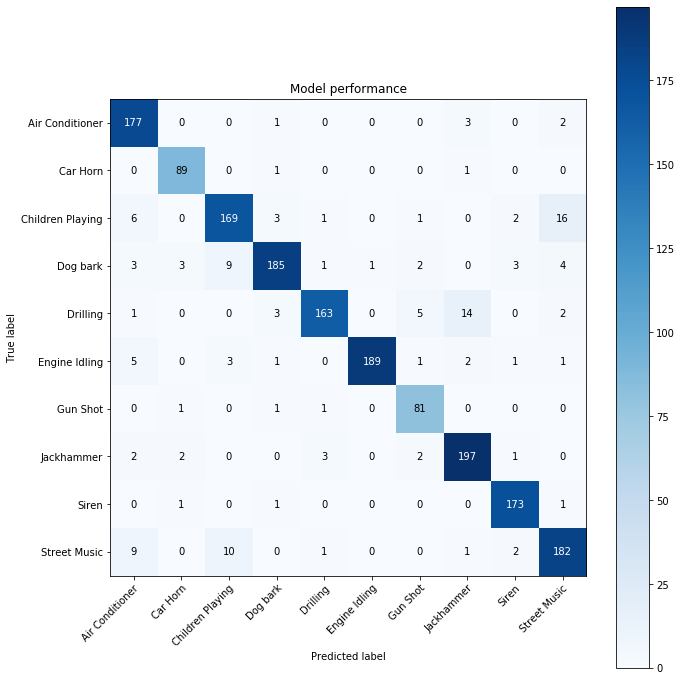

In [38]:
# Ceros after comma (only for printing)
np.set_printoptions(precision=2)

# Class names in the correct order
classes = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Ground true classes: index order is preserved!
y_pred = y_test_encoded.argmax(axis=1).tolist()

# Predictions
preds = model.predict(X_test).argmax(axis=1).tolist()

# Prepare the confusion matrix graph
cm, ax = plot_confusion_matrix(y_pred, 
                               preds, 
                               classes,
                               normalize=False,
                               title="Model performance")

# Plot the confusion matrix
plt.show()


#### Observations

We have some classes with very low misclassification rate (good accuracy): 
* Air Conditioner
* Car Horn
* Gun shot
* Siren
* Jack-Hammer

<br/>
There are some interesting cases where the misclassified sample may have very similar patterns to those of the predicted class, for example:<br/>

* Children Playing and Street Music
* Drilling and Jack Hammer: actually the difference between this two classes is subtle, a big misclassification rate was expected at this stage.

<br/>
In other cases, a class was misclassified as some other in many cases, but none or just a few in the opposite way: 


* Dog Barks classified as Children Playing
* Engine Idling classified as Air Conditioner


<br/>
<br/>

### Per class accuracy  
Using the data from the consufion matrix we can elaborate a per-class accuracy table:<br/>
<br/>
As we observe we have good classification results for some classes like Air Conditioning or Siren, but not so good for others like Street Music or Children Playing; I'm expecting to see this cases being misclasified in the confusion matrix, most probably, because the model is not yet being able to distinguish particular patterns for those classes.

In [40]:
# Find per-class accuracy from the confusion matrix data
accuracies = acc_per_class(cm)

pd.DataFrame({
    'CLASS': classes,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

CLASS   ACCURACY
8             Siren  98.295455
1          Car Horn  97.802198
0   Air Conditioner  96.721311
6          Gun Shot  96.428571
7        Jackhammer  95.169082
5     Engine Idling  93.103448
9      Street Music  88.780488
3          Dog bark  87.677725
4          Drilling  86.702128
2  Children Playing  85.353535

#### How classes with less samples did perform

In the first notebook we saw that two particular classes had much less samples than the others (of average 1000 samples each); Car Horn and Gunshot: 

* Both classes have over 95% accuracy
* The rate of other classes being misclassified by any of this two is also very low

<br/>
Most probably, having less samples for this classes is not a problem at all.

### Exploring the misclassified
Note that results may vary between different training sessions because of the stocastic nature of the training process. The presented results are likely be generic, but are still bound to the training session registered by this notebook.

In [ ]:
# Lets first add a predictions column to our test metadata so we can access the sound files
test_meta['pred'] = preds

#### 1. Children playing as Street music

In [67]:
# Find the target misclassified ocurrencies
children_as_music = test_meta[(test_meta['classID'] == 2) & (test_meta['pred'] == 9)]
files = []
for idx, row in children_as_music.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [68]:
print("Children playing as Street music: {} ocurrencies".format(len(children_as_music)))

# Manully set the file index
index = 1
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Children playing as Street music: 16 ocurrencies

True category: children_playing
File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold8/76266-2-0-40.wav


#### Observations

* There are many cases where you barely hear any children playing
* In many cases there is significantly loud rhythmic percussive sound, the best example may be: "fold8/72015-2-0-1.wav"
* In several cases you won't hear any children playing instead some adult voices, traffic and loud percussive patterns in the low frequencies

<br/>
<br/>

#### 2. Dog Bark as Car Horn

In [65]:
# Find the target misclassified ocurrencies
bark_as_horn = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 1)]
files = []
for idx, row in bark_as_horn.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [66]:
print("Dog Bark as Car Horn: {} ocurrencies".format(len(bark_as_horn)))

# Set the file index
index = 2
   
# Display results
print("\nTrue category: {}\n".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Car Horn: 3 ocurrencies

True category: dog_bark

File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold1/51022-3-30-4.wav


#### Observations

* All cases are extremly noisy
* In the last case you can hear something like a cricket sound, no dog bark is even distinguishable

<br/>
<br/>

#### 3. Drilling as Jack Hammer

In [73]:
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)


In [77]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 5
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Jack Hammer: 14 ocurrencies

True category: drilling
File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold7/130961-4-2-1.wav


#### Observations

This are perhaps the most similar classes: a continuous percussive sound in a regular frequency. What makes the difference is that Driller's sound is more treble and fast while Jack Hammer's more bass and slow.

* Most of the misclassified sound are drillers generating percussive bass sounds -many modern drillers will have a switch to function as a percussive hammer!
* Some samples actually sound nothing like a driller and everything like a Jack Hammer. Maybe only the speed is faster than the usual Jack Hammer sound and the model did not catch that pattern?

<br/>
<br/>

#### 4. Dog Bark as Children Playing

In [90]:
# Drilling as Air Conditioner
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [98]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 5
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Children Playing: 9 ocurrencies

True category: dog_bark
File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold1/31323-3-0-1.wav


#### Observations

* There are cases where there is a dog bark sound but also children playing in foreground
* Some cases have very low volume, with high ambience sound present
* There are also very clear samples of dog bark that have not been clearly identified

<br/>
<br/>

#### 5. Street Music as Air Conditioner

In [103]:
# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [106]:
print("Street Music as Air Conditioner: {} ocurrencies".format(len(music_as_aircon)))

# Manully set the file index
index = 1

prediction = predict_from_file(files[index], num_rows, num_columns, num_channels)

print("False positive probability:", prediction[1][0])
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Street Music as Air Conditioner: 9 ocurrencies
False positive probability: 0.5243753

True category: street_music
File: /mnt/disks/disk-1/projects/urban-audio-classifier/UrbanSound8K/audio/fold10/155241-9-0-79.wav


#### Observations

Despite of some very clear misclassification examples, there are many cases where the street music sounds very weakly in the background while, at the same time, there is much continuous noise in the mid-to-low frequencies.
<br/>
Street ambiance sound seems to be a common factor in the two classes, the model seems to fail distinguishing the most essential patterns that describe this two classes.
<br/>
<br/>

## Conclusions

<br/>
We achieved some very acceptable results and a piece of work to start experimenting with tweaking and optimizing once we develop some hypothesis about what the model may be doing wrong and how can we solve for it.<br/> 

#### Odd kernel sizes
A very important change was to set the kernel size of the last two convolutional layers from (2x2) to (3x3). With this change I could achieve slightly better results while also reducing about 40 epochs.<br/>
<br/>
Despite many audio processing with CNN examples you may find that uses 2x2 kernels, there is a principle reason why using odd kernel sizes in convolutional layers:<br/>
Basically, because we are looking to build each convolution window with all possible neighbor around a source position. Therefore, a 3x3 matrix has a central position at (for example) <2,2> with all it's possible neighbor positions (8) around it.<br/>

#### Pattern detection issues
There are clear signs that model is not being able to correctly classify data when the objective sound is not loud enough or it competes strongly with other sound sources observed in the same audio sample.<br/>
<br/>
Some particular cases -like air conditioning- may have patterns -like a constant low frequency- that are likely to appear in other scenarios of outdoors footage.<br/>
<br/>
Drilling and Jack Hammer classes are maybe the most misclassified ones. At the moment, my hypothesis is that both sound types share a very similar pattern (that percussive sound that repeats in a regular frequency), and the key difference between Drilling and Jack Hammer is the speed in which that pattern repeats itself and the pitch: while Jack Hammer sounds bass and slow (percussions over time), drilling is more treble and faster.<br/>
<br/>
Similarly, Children Playing and Street Music share a common pattern: the street ambiance sound. Maybe once we add more layers the model will be able to distinguish more precise features that describe classes.<br/>

#### Overfitting
At first I struggled quite a bit to counter overfitting due to more complex model architectures; It got better once I simplified the model and added Spatial Dropout and Batch Normalization.<br/>
<br/>
Once I got 91~92% accuracy on the test set, it started to get hard to raise it further while also keeping the loss difference between Train and Test lower than 4%.<br/>

#### Next
The next step is to understand what the model may be doing wrong and see how we can add features to our model for better generalization but also for more detailed pattern recognition.
<br/>
<br/>